# Getting started

In [1]:
#!pip install neuralforecast

### Import libraries

In [26]:
import neuralforecast as nf
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch as t
import matplotlib.pyplot as plt

### Dataset

In [3]:
Y_df, _, S_df = nf.data.datasets.m5.M5.load('data')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df.head()

,unique_id,ds,y
0,FOODS_1_001_CA_1,2011-01-29,3.0
1,FOODS_1_001_CA_1,2011-01-30,0.0
2,FOODS_1_001_CA_1,2011-01-31,0.0
3,FOODS_1_001_CA_1,2011-02-01,1.0
4,FOODS_1_001_CA_1,2011-02-02,4.0


In [4]:
Y_df = Y_df.merge(S_df, how='left', on=['unique_id'])

In [5]:
Y_df = Y_df[['item_id', 'ds', 'y']].groupby(['item_id', 'ds']).sum().reset_index()

In [6]:
Y_df = Y_df.rename(columns={'item_id': 'unique_id'})

In [7]:
Y_df = Y_df.groupby('unique_id').tail(100)

In [8]:
uids = Y_df['unique_id'].unique()[:100]
Y_df = Y_df.query('unique_id in @uids').reset_index(drop=True)
Y_df['unique_id'] = Y_df['unique_id'].astype(str)

In [9]:
Y_df

,unique_id,ds,y
0,HOBBIES_1_001,2016-03-12,8.0
1,HOBBIES_1_001,2016-03-13,6.0
2,HOBBIES_1_001,2016-03-14,5.0
3,HOBBIES_1_001,2016-03-15,6.0
4,HOBBIES_1_001,2016-03-16,5.0
...,...,...,...
9995,HOBBIES_1_104,2016-06-15,2.0
9996,HOBBIES_1_104,2016-06-16,5.0
9997,HOBBIES_1_104,2016-06-17,2.0
9998,HOBBIES_1_104,2016-06-18,6.0


### Split train/test sets

In [11]:
output_size = 7
Y_df_test = Y_df.groupby('unique_id').tail(output_size)
Y_df_train = Y_df.drop(Y_df_test.index)

### Define WindowsDataset and TimeSeriesLoader

In [12]:
input_size = 4 * output_size

In [13]:
train_mask_df, val_mask_df, _ = nf.experiments.utils.get_mask_dfs(
    Y_df=Y_df_train,
    ds_in_val=3 * output_size,
    ds_in_test=0
)

In [14]:
plot_df = Y_df_train.merge(
    train_mask_df.drop('available_mask', axis=1).rename(columns={'sample_mask': 'sample_mask_train'}),
    how='left',
    on=['unique_id', 'ds']
).merge(
    val_mask_df.drop('available_mask', axis=1).rename(columns={'sample_mask': 'sample_mask_val'}),
    how='left',
    on=['unique_id', 'ds']
)

In [15]:
plot_df['y_train'] = np.where(plot_df['sample_mask_train'] == 1, plot_df['y'], np.nan)
plot_df['y_val'] = np.where(plot_df['sample_mask_val'] == 1, plot_df['y'], np.nan)

<AxesSubplot:xlabel='ds'>

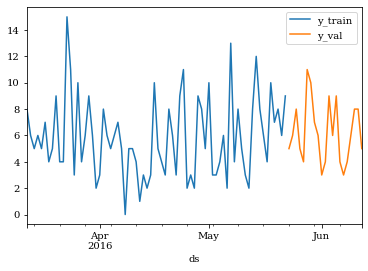

In [16]:
plot_df.query('unique_id == "HOBBIES_1_001"').set_index('ds')[['y_train', 'y_val']].plot()

In [17]:
train_dataset = nf.data.tsdataset.TimeSeriesDataset(
    Y_df=Y_df_train, 
    input_size=input_size,
    output_size=output_size,
    mask_df=train_mask_df
)

/Users/fedex/projects/neuralforecast/neuralforecast/data/tsdataset.py:208: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X.drop(['unique_id', 'ds'], 1, inplace=True)


In [18]:
val_dataset = nf.data.tsdataset.TimeSeriesDataset(
    Y_df=Y_df_train, 
    input_size=input_size,
    output_size=output_size,
    mask_df=val_mask_df
)

In [19]:
train_loader = nf.data.tsloader.TimeSeriesLoader(
    train_dataset, batch_size=256, 
    shuffle=True
)

In [20]:
val_loader = nf.data.tsloader.TimeSeriesLoader(
    val_dataset, 
    batch_size=1
)

### Define model

In [21]:
model = nf.models.esrnn.mqesrnn.MQESRNN(
    n_series=train_dataset.n_series,
    input_size=input_size, output_size=output_size,
    n_x=0, 
    frequency='D', 
    cell_type='GRU',
    state_hsize=64,
    training_percentiles=[5, 20, 50, 80, 95],
    testing_percentiles=[5, 20, 50, 80, 95],
    loss='MQ'
)

### Train model with early stopping

In [22]:
early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss")

trainer = pl.Trainer(max_epochs=100,
                     gpus=-1 if t.cuda.is_available() else 0,
                     callbacks=[early_stopping])

trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | model | _ESRNN | 95.2 K
---------------------------------
95.2 K    Trainable params
1         Non-trainable params
95.2 K    Total params
0.381     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/fedex/opt/miniconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/fedex/opt/miniconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/fedex/opt/miniconda3/envs/neuralforecast/lib/python3.7/

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [23]:
Y_df_forecast = model.forecast(Y_df_train)
Y_df_forecast.head()

INFO:root:Train Validation splits

INFO:root:                    ds           
                   min        max
sample_mask                      
0           2016-03-12 2016-06-12
1           2016-06-13 2016-06-19
INFO:root:
Total data 			10000 time stamps 
Available percentage=100.0, 	10000 time stamps 
Insample  percentage=7.0, 	700 time stamps 
Outsample percentage=93.0, 	9300 time stamps 

/Users/fedex/projects/neuralforecast/neuralforecast/data/tsdataset.py:208: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X.drop(['unique_id', 'ds'], 1, inplace=True)
INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
/Users/fedex/projects/neuralforecast/neuralforecast/data/tsloader.py:47: UserWarning: This class wraps 

Predicting: 0it [00:00, ?it/s]

,unique_id,ds,y_p5,y_p20,y_p50,y_p80,y_p95
0,HOBBIES_1_001,2016-06-13,1.549767,4.009396,5.008271,7.024125,8.918941
1,HOBBIES_1_001,2016-06-14,1.089004,3.805077,4.908763,6.963377,9.433008
2,HOBBIES_1_001,2016-06-15,1.273826,3.655630,5.127580,6.970573,9.318736
3,HOBBIES_1_001,2016-06-16,0.729203,3.711207,4.839077,6.770388,9.245943
4,HOBBIES_1_001,2016-06-17,1.228527,3.362679,5.023280,7.040047,9.557949


In [24]:
Y_df_plot = Y_df_test.merge(Y_df_forecast, how='left', on=['unique_id', 'ds'])

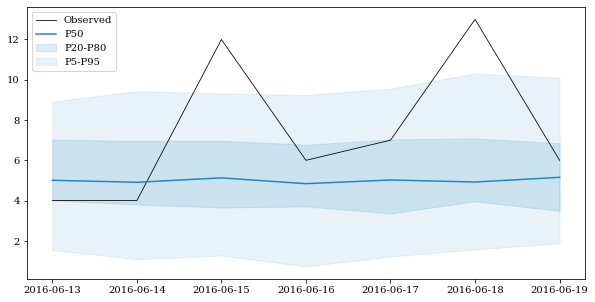

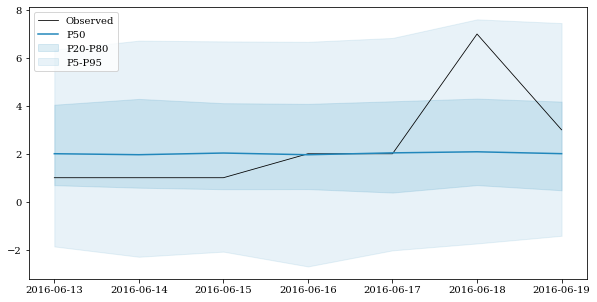

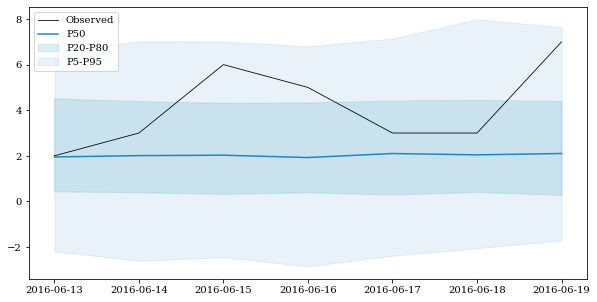

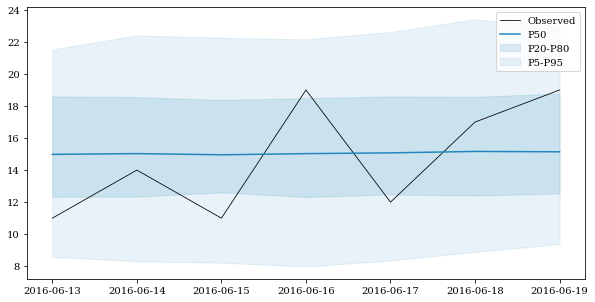

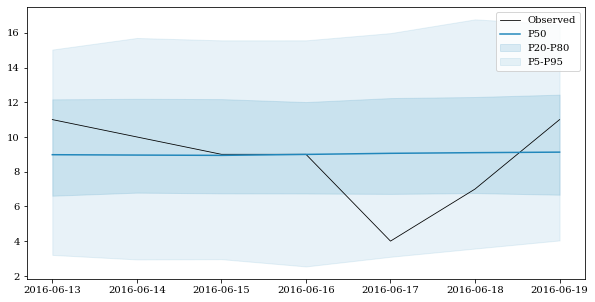

In [66]:
for uid in Y_df_plot['unique_id'].unique()[:5]:
    df_plot = Y_df_plot.query('unique_id == @uid')
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_plot['ds'], df_plot['y'], label='Observed', color='black', linewidth=0.8)
    ax.plot(df_plot['ds'], df_plot['y_p50'], label='P50', color='#2187bb')
    ax.fill_between(df_plot['ds'], df_plot['y_p20'], df_plot['y_p80'], color='#2187bb', alpha=.15, label='P20-P80')
    ax.fill_between(df_plot['ds'], df_plot['y_p5'], df_plot['y_p95'], color='#2187bb', alpha=.10, label='P5-P95')
    ax.legend()
    